# DATA DEFINTTION

**Kolom pada dataset**

---
<BR><BR>1. trans_date_trans_time:<BR>Waktu transaksi. Dapat digunakan untuk mendeteksi pola waktu (misal transaksi yang sering terjadi pada waktu yang tidak wajar bisa dicurigai sebagai fraud). 
<BR><BR>2. cc_num:<BR>Nomor kartu kredit. Informasi penting terkait pengguna kartu, tetapi tidak langsung membantu mendeteksi fraud kecuali ada pola dari penggunaan kartu yang tidak biasa.
<BR><BR>3. merchant:<BR>Nama merchant (penjual). Merchant tertentu mungkin lebih sering terlibat dalam transaksi fraud, sehingga bisa membantu mendeteksi risiko terkait merchant.
<BR><BR>4. category:<BR>Kategori transaksi. Fraud mungkin lebih sering terjadi dalam kategori tertentu seperti barang mewah atau hiburan, yang memiliki nilai transaksi lebih tinggi.
<BR><BR>5. amt:<BR>Jumlah uang dalam transaksi. Nilai transaksi yang sangat besar atau tidak sesuai dengan pola belanja biasanya bisa menjadi tanda fraud.
<BR><BR>6. first:<BR>Nama depan pemegang kartu. Tidak terlalu relevan dalam mendeteksi fraud secara langsung.
<BR><BR>7. last:<BR>Nama belakang pemegang kartu. Sama seperti first, tidak relevan secara langsung.
<BR><BR>8. gender:<BR>Jenis kelamin pemegang kartu. Bisa digunakan untuk melihat pola demografis terkait fraud, meskipun tidak secara langsung mengindikasikan fraud.
<BR><BR>9. street:<BR>Alamat jalan pemegang kartu. Dapat digunakan dalam deteksi anomali jika lokasi transaksi berbeda jauh dari alamat pemegang kartu.
<BR><BR>10. city:<BR>Kota pemegang kartu. Sama seperti street, dapat digunakan untuk memeriksa ketidaksesuaian antara lokasi pemegang kartu dan transaksi.
<BR><BR>11. state:<BR>Negara bagian pemegang kartu. Sama dengan city, bisa mendeteksi anomali lokasi.
<BR><BR>12. zip:<BR>Kode pos pemegang kartu. Sama dengan city dan state, bisa membantu mendeteksi anomali geografis.
<BR><BR>13. lat:<BR>Garis lintang lokasi pemegang kartu. Lokasi geografis dapat membantu mendeteksi ketidaksesuaian jika dibandingkan dengan lokasi transaksi.
<BR><BR>14. long:<BR>Garis bujur lokasi pemegang kartu. Sama dengan lat, membantu mendeteksi lokasi.
<BR><BR>15. city_pop:<BR>Populasi kota pemegang kartu. Bisa digunakan untuk memahami risiko terkait daerah, misalnya daerah padat penduduk mungkin memiliki lebih banyak transaksi dan risiko.
<BR><BR>16. job:<BR>Pekerjaan pemegang kartu. Pekerjaan dengan penghasilan tinggi mungkin lebih rentan terhadap fraud karena lebih sering terlibat dalam transaksi besar.
<BR><BR>17. dob:<BR>Tanggal lahir pemegang kartu. Usia pemegang kartu bisa menjadi faktor, misalnya kelompok usia tertentu mungkin lebih rentan terhadap fraud.
<BR><BR>18. trans_num:<BR>ID unik untuk transaksi. Tidak relevan dalam deteksi fraud secara langsung.
<BR><BR>19. unix_time:<BR>Waktu transaksi dalam format unix. Sama seperti trans_date_trans_time, membantu dalam menganalisis pola waktu.
<BR><BR>20. merch_lat:<BR>Garis lintang merchant. Dapat digunakan untuk mendeteksi ketidaksesuaian antara lokasi merchant dan pemegang kartu.
<BR><BR>21. merch_long:<BR>Garis bujur merchant. Sama seperti merch_lat, membantu mendeteksi anomali lokasi.
<BR><BR>22. is_fraud:<BR>Label apakah transaksi adalah fraud (0 = tidak fraud, 1 = fraud). Ini adalah target yang perlu diprediksi.


# IMPORTS

In [1]:
#general imports
import pandas as pd
import numpy as np
from datetime import datetime

#for Splitting
from sklearn.model_selection import train_test_split

#for handling imbalance data
from imblearn.over_sampling import SMOTE

#for modelling
from sklearn.ensemble import AdaBoostClassifier
    # from sklearn.tree import DecisionTreeClassifier #ganti pakai random forest aja ah
from sklearn.ensemble import RandomForestClassifier

#for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#for visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# DATA LOADING

In [2]:

df_train = pd.read_csv('./archive/fraudTrain.csv')

#oh iya baris di bawah ini nanti dimatikan saja
#karena masih coba-coba codingnya dan di ulang, pakai 1000 baris dulu biar cepet aja
#ntar kalau mau mulai pemodelan benerannya baru  pakai full data
# df_train.sample(1000).to_csv('df_train_sampling.csv', index=False) #buang sekidikit ke csv untuk analisa ringan
# df_train=df_train.sample(1000)


In [3]:
## untuk save dan load pickle

import pickle

def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model_from_pickle(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model




# EDA + Data Preparation

In [4]:
# miniEDAtoPDF  nyomot dari internet


import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet

def mini_eda(df, pdf_filename):
    # Create a PDF file
    pdf = SimpleDocTemplate(pdf_filename, pagesize=letter)
    styles = getSampleStyleSheet()
    story = []

    # Function to format numbers
    def format_number(num):
        return f"{num:,.2f}"

    # Iterate through each column in the dataframe
    for col in df.columns:
        # Count of non-null rows
        non_null_count = df[col].count()
        story.append(Paragraph(f"<b>Column: {col}</b>", styles['Heading2']))
        story.append(Paragraph(f"Non-Null Rows: {format_number(non_null_count)}", styles['BodyText']))

        # Missing values
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        story.append(Paragraph(f"Missing Values: {format_number(missing_count)} ({format_number(missing_pct)}%)", styles['BodyText']))

        # Distinct values
        distinct_count = df[col].nunique()
        distinct_pct = (distinct_count / len(df)) * 100
        story.append(Paragraph(f"Distinct Values: {format_number(distinct_count)} ({format_number(distinct_pct)}%)", styles['BodyText']))

        # Check if the column is numerical or categorical
        if pd.api.types.is_numeric_dtype(df[col]):
            # Numerical column
            min_val = df[col].min()
            max_val = df[col].max()
            mean_val = df[col].mean()
            q5 = df[col].quantile(0.05)
            q25 = df[col].quantile(0.25)
            q50 = df[col].quantile(0.50)
            q75 = df[col].quantile(0.75)
            q95 = df[col].quantile(0.95)
            story.append(Paragraph(f"Min: {format_number(min_val)}", styles['BodyText']))
            story.append(Paragraph(f"Max: {format_number(max_val)}", styles['BodyText']))
            story.append(Paragraph(f"Mean: {format_number(mean_val)}", styles['BodyText']))
            story.append(Paragraph(f"5th Percentile (Q5): {format_number(q5)}", styles['BodyText']))
            story.append(Paragraph(f"25th Percentile (Q25): {format_number(q25)}", styles['BodyText']))
            story.append(Paragraph(f"50th Percentile (Q50): {format_number(q50)}", styles['BodyText']))
            story.append(Paragraph(f"75th Percentile (Q75): {format_number(q75)}", styles['BodyText']))
            story.append(Paragraph(f"95th Percentile (Q95): {format_number(q95)}", styles['BodyText']))

            # Check if the column can be divided into less than 20 groups
            if distinct_count <= 20:
                # Plot distribution
                plt.figure(figsize=(10, 6))
                df[col].value_counts().sort_index().plot(kind='bar')
                plt.title(f"Distribution of {col}")
                plt.xlabel(col)
                plt.ylabel("Count")
                img_filename = f"{col}_distribution.png"
                plt.savefig(img_filename)
                plt.close()
                story.append(Spacer(1, 12))
                story.append(Image(img_filename, width=400, height=300))
            else:
                story.append(Paragraph(f"Min: {format_number(min_val)}", styles['BodyText']))
                story.append(Paragraph(f"Max: {format_number(max_val)}", styles['BodyText']))
        else:
            # Categorical column
            story.append(Paragraph(f"Distinct Values: {format_number(distinct_count)}", styles['BodyText']))

            # Top 10 + others
            top_10 = df[col].value_counts().nlargest(10)
            others_count = len(df) - top_10.sum()
            others_pct = (others_count / len(df)) * 100
            story.append(Paragraph("Top 10 + Others:", styles['BodyText']))
            for value, count in top_10.items():
                pct = (count / len(df)) * 100
                story.append(Paragraph(f"{value}: {format_number(count)} ({format_number(pct)}%)", styles['BodyText']))
            story.append(Paragraph(f"Others: {format_number(others_count)} ({format_number(others_pct)}%)", styles['BodyText']))

            # Plot distribution
            plt.figure(figsize=(10, 6))
            top_10.plot(kind='bar')
            plt.title(f"Top 10 Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Count")
            img_filename = f"{col}_top10_distribution.png"
            plt.savefig(img_filename)
            plt.close()
            story.append(Spacer(1, 12))
            story.append(Image(img_filename, width=400, height=300))

        # Add a page break after each column
        story.append(PageBreak())

    # Build the PDF
    pdf.build(story)

# Example usage
# df = pd.read_csv('your_data.csv')
# mini_eda(df, 'eda_report.pdf')




In [5]:
mini_eda(df_train, 'eda_report__df_train.pdf')

In [6]:
df_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [8]:
# tukang stop proses jupyter , uncomment to break the running process of "Run All" 

## convert date and time

In [9]:
# Convert kolom 'trans_date_trans_time' ke format datetime
df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])

# Ambil komponen waktu dari kolom 'trans_date_trans_time'
df_train['trans_year'] = df_train['trans_date_trans_time'].dt.year
df_train['trans_month'] = df_train['trans_date_trans_time'].dt.month
df_train['trans_date'] = df_train['trans_date_trans_time'].dt.day
df_train['trans_hour'] = df_train['trans_date_trans_time'].dt.hour
df_train['trans_dow'] = df_train['trans_date_trans_time'].dt.dayofweek  # Hari dalam minggu (0 = Senin, 6 = Minggu)

# Tampilkan beberapa baris pertama buat ngecek hasilnya
df_train.sample(15)[['trans_date_trans_time', 'trans_year', 'trans_month', 'trans_date', 'trans_hour', 'trans_dow']]


,trans_date_trans_time,trans_year,trans_month,trans_date,trans_hour,trans_dow
264405,2019-05-11 18:20:50,2019,5,11,18,5
457489,2019-07-21 16:30:29,2019,7,21,16,6
174480,2019-04-01 10:58:39,2019,4,1,10,0
261870,2019-05-10 17:43:19,2019,5,10,17,4
1082570,2020-03-25 12:43:08,2020,3,25,12,2
1189897,2020-05-11 23:51:43,2020,5,11,23,0
361656,2019-06-17 06:34:42,2019,6,17,6,0
296200,2019-05-25 15:21:28,2019,5,25,15,5
208317,2019-04-16 05:23:48,2019,4,16,5,1
26297,2019-01-15 22:20:32,2019,1,15,22,1


In [10]:
# Convert kolom 'unix_time' ke format datetime
df_train['unix_time'] = pd.to_datetime(df_train['unix_time'], unit='s')

# Tambahin 7 tahun ke 'unix_time'
seconds_in_7_years = 7 * 365 * 24 * 60 * 60  # Hitung detik dalam 7 tahun
df_train['unix_time'] = df_train['unix_time'] + pd.Timedelta(seconds=seconds_in_7_years)

# Ambil komponen waktu dari kolom 'unix_time'
df_train['unix_year'] = df_train['unix_time'].dt.year+7
df_train['unix_month'] = df_train['unix_time'].dt.month
df_train['unix_date'] = df_train['unix_time'].dt.day
df_train['unix_hour'] = df_train['unix_time'].dt.hour
df_train['unix_dow'] = df_train['unix_time'].dt.dayofweek  # Hari dalam minggu (0 = Senin, 6 = Minggu)

# Tampilkan beberapa baris pertama buat ngecek hasilnya
df_train.sample(10)[['unix_time', 'unix_year', 'unix_month', 'unix_date', 'unix_hour', 'unix_dow']]


,unix_time,unix_year,unix_month,unix_date,unix_hour,unix_dow
856302,2019-12-15 14:02:27,2026,12,15,14,6
906950,2019-12-27 14:37:52,2026,12,27,14,4
328277,2019-06-04 17:39:57,2026,6,4,17,1
12443,2019-01-06 04:23:51,2026,1,6,4,6
1032298,2020-03-01 14:56:57,2027,3,1,14,6
130594,2019-03-12 02:06:00,2026,3,12,2,1
868872,2019-12-18 21:34:27,2026,12,18,21,2
1295822,2020-06-19 04:43:39,2027,6,19,4,4
908973,2019-12-27 22:01:10,2026,12,27,22,4
723888,2019-11-03 21:37:45,2026,11,3,21,6


In [11]:
# Membandingkan trans time dan unix time
df_train.sample(15)[['trans_date_trans_time', 'trans_year', 'trans_month', 'trans_date', 'trans_hour', 'trans_dow','unix_time', 'unix_year', 'unix_month', 'unix_date', 'unix_hour', 'unix_dow']]

,trans_date_trans_time,trans_year,trans_month,trans_date,trans_hour,trans_dow,unix_time,unix_year,unix_month,unix_date,unix_hour,unix_dow
417339,2019-07-07 12:07:13,2019,7,7,12,6,2019-07-06 12:07:13,2026,7,6,12,5
666615,2019-10-11 14:49:22,2019,10,11,14,4,2019-10-10 14:49:22,2026,10,10,14,3
1209003,2020-05-20 02:51:02,2020,5,20,2,2,2020-05-18 02:51:02,2027,5,18,2,0
547550,2019-08-22 16:52:55,2019,8,22,16,3,2019-08-21 16:52:55,2026,8,21,16,2
745081,2019-11-15 02:25:50,2019,11,15,2,4,2019-11-14 02:25:50,2026,11,14,2,3
1291229,2020-06-19 08:50:17,2020,6,19,8,4,2020-06-17 08:50:17,2027,6,17,8,2
573747,2019-08-31 22:53:09,2019,8,31,22,5,2019-08-30 22:53:09,2026,8,30,22,4
127794,2019-03-11 15:48:05,2019,3,11,15,0,2019-03-10 15:48:05,2026,3,10,15,6
612465,2019-09-16 21:54:09,2019,9,16,21,0,2019-09-15 21:54:09,2026,9,15,21,6
103611,2019-03-01 17:15:51,2019,3,1,17,4,2019-02-28 17:15:51,2026,2,28,17,3


## menghitung selisih hari saat transaksi dan pembukuan

In [12]:
# Buat kolom 'dow_dif' selisih hari transaksi dengan pembukan
df_train['dow_dif'] = df_train.apply(
    lambda row: row['trans_dow'] - row['unix_dow'] 
    if row['trans_dow'] - row['unix_dow'] >= 0 
    else row['trans_dow'] - row['unix_dow'] + 7, axis=1)


In [13]:
# Tampilkan hasilnya
df_train.sample(30)[['unix_dow', 'trans_dow', 'dow_dif']].head()

,unix_dow,trans_dow,dow_dif
214780,3,4,1
939425,2,3,1
864816,1,2,1
199016,3,4,1
1065147,6,1,2


## menghitung jarak

In [14]:
# Fungsi untuk menghitung jarak menggunakan rumus Haversine (minta sama chatgpt)

def haversine(lat1, lon1, lat2, lon2):
    # Konversi dari derajat ke radian
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Rumus Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    # Radius bumi dalam kilometer (bisa diganti dengan 6371 untuk km atau 3958.8 untuk miles)
    R = 6371  # Radius bumi dalam kilometer
    distance = R * c
    return distance

In [15]:
# Buat kolom 'card_merchant_distance' dengan menghitung jarak
df_train['card_merchant_distance_km'] = df_train.apply(
    lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1
)

#membuat grouping jarak per 10 km, akan digunakan untuk  membuat kelompok fraud rate
df_train['card_merchant_distance_km_grp']=(df_train['card_merchant_distance_km']//10)*10

# Tampilkan hasil
df_train.sample(10)[['lat', 'long', 'merch_lat', 'merch_long', 'card_merchant_distance_km','card_merchant_distance_km_grp']]

,lat,long,merch_lat,merch_long,card_merchant_distance_km,card_merchant_distance_km_grp
538834,40.6284,-76.1950,40.220665,-75.295465,88.619082,80.0
304093,34.7789,-86.5438,35.615146,-87.314645,116.414287,110.0
113789,38.8938,-86.5246,37.920082,-86.500729,108.292477,100.0
946883,36.4715,-82.4834,35.969450,-82.573994,56.413842,50.0
196936,39.3900,-88.9597,38.879289,-89.736332,87.816510,80.0
1253099,41.0442,-73.9609,42.033268,-73.831657,110.504108,110.0
144193,45.7801,-111.1439,45.353216,-110.580600,64.621553,60.0
673997,41.6858,-90.3706,40.983031,-89.424085,111.137271,110.0
1009862,44.8755,-88.1555,44.570946,-87.439863,65.905033,60.0
529753,41.0001,-78.2357,41.031141,-77.981802,21.579853,20.0


## menghitung umur saat transaksi

In [16]:
# Convert 'dob' ke datetime format supaya bisa diproses
df_train['dob'] = pd.to_datetime(df_train['dob'])

# Hitung umur berdasarkan selisih antara 'unix_year' dan tahun dari 'dob'
df_train['person_age'] = df_train['unix_year'] - df_train['dob'].dt.year

#membuat grouping umu per 10 tahun, akan digunakan untuk  membuat kelompok fraud rate
df_train['person_age_grp']=(df_train['person_age']//10)*10

# Tampilkan hasilnya
df_train.sample(10)[['dob', 'unix_year', 'person_age','person_age_grp']]

,dob,unix_year,person_age,person_age_grp
1293400,1952-04-02,2027,75,70
106967,1977-02-22,2026,49,40
1192740,1984-02-29,2027,43,40
693827,1983-11-10,2026,43,40
926564,1952-05-07,2027,75,70
424825,1978-03-04,2026,48,40
1229165,1926-07-12,2027,101,100
1239116,1986-11-24,2027,41,40
958687,1972-05-04,2027,55,50
153439,1992-11-20,2026,34,30


## fraud rate by unix_hour

In [17]:
#setiap jam di group, lalu dihitung jumlah transaksinya (jml barisnya aka size nya) 
# dan jumlah transaksi fraud nya (is_fraud==1)--(di jumlah saja)
hourly_data = df_train.groupby('unix_hour').agg(
    total_transactions=('is_fraud', 'size'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()

#hitung rate nya
hourly_data['fraud_rate_by_unix_hour'] = hourly_data['fraud_cases'] / hourly_data['total_transactions']

#masukkan kembali ke dataframe utama
df_train = df_train.merge(hourly_data[['unix_hour', 'fraud_rate_by_unix_hour']], on='unix_hour', how='left')

#melihat isi df_train yang baru secara random sebanyak 10 baris
df_train.sample(10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_month,unix_date,unix_hour,unix_dow,dow_dif,card_merchant_distance_km,card_merchant_distance_km_grp,person_age,person_age_grp,fraud_rate_by_unix_hour
549350,549350,2019-08-23 12:35:42,3511378610369890,fraud_Fisher-Schowalter,shopping_net,7.05,James,Cooper,M,663 Ramirez Trace Apt. 951,...,8,22,12,3,1,63.369277,60.0,53,50,0.001027
1143678,1143678,2020-04-21 11:05:17,345060451158891,fraud_Kuhic Inc,grocery_pos,174.27,Brian,Perez,M,78652 Scott Ports,...,4,19,11,6,2,105.611654,100.0,67,60,0.000998
865109,865109,2019-12-18 21:02:36,340953839692349,fraud_Dare-Marvin,entertainment,6.39,Tyler,Wright,M,615 Clarke Spring Apt. 172,...,12,17,21,1,1,66.388307,60.0,46,40,0.001129
912180,912180,2019-12-29 12:26:24,676102124465,fraud_Little Ltd,kids_pets,22.32,Natasha,Mclaughlin,F,8699 Lindsay Ford Apt. 486,...,12,28,12,5,1,54.804496,50.0,41,40,0.001027
1158569,1158569,2020-04-28 03:28:46,4116554952971686,fraud_Pacocha-Bauch,shopping_pos,2.98,Bridget,Bowen,F,49120 Regina Island Apt. 170,...,4,26,3,6,2,58.268904,50.0,93,90,0.014239
2498,2498,2019-01-02 02:37:20,3526826139003047,fraud_Bartoletti-Wunsch,gas_transport,55.12,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,12,31,2,0,2,22.406355,20.0,70,70,0.014652
755420,755420,2019-11-18 21:28:51,30143713661454,"fraud_Bahringer, Osinski and Block",food_dining,32.04,Nicholas,Thornton,M,5270 Megan Burg Suite 756,...,11,17,21,6,1,24.384912,20.0,84,80,0.001129
166631,166631,2019-03-29 15:28:02,30131826429364,"fraud_Hahn, Bahringer and McLaughlin",personal_care,5.55,Brianna,Foley,F,57256 Raymond Ports,...,3,28,15,3,1,52.013712,50.0,32,30,0.001208
986358,986358,2020-02-06 02:53:00,6592074504369261,fraud_Mante Group,misc_net,2.76,Amanda,Molina,F,8425 Daniel Knolls Suite 288,...,2,5,2,2,1,41.809371,40.0,55,50,0.014652
9347,9347,2019-01-06 20:47:53,4683638447911,fraud_Auer LLC,personal_care,79.79,Daniel,Boyd,M,8925 Nicholas Points,...,1,4,20,4,2,66.428494,60.0,54,50,0.000952


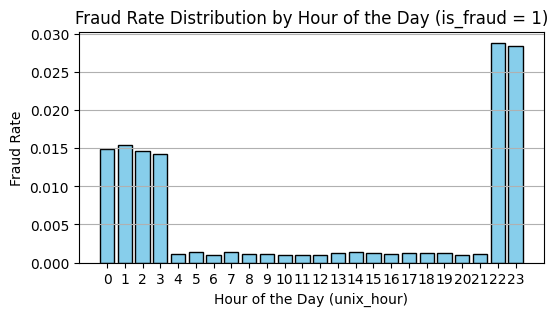

In [18]:
import matplotlib.pyplot as plt

# Plot the fraud rate for each hour
plt.figure(figsize=(6, 3))
plt.bar(hourly_data['unix_hour'], hourly_data['fraud_rate_by_unix_hour'], color='skyblue', edgecolor='black')
plt.title('Fraud Rate Distribution by Hour of the Day (is_fraud = 1)')
plt.xlabel('Hour of the Day (unix_hour)')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24))  # Display hours from 0 to 23
plt.grid(True, axis='y')
plt.show()


## fraud rate by category


In [19]:
# menerapkan cara kerja yang sama, dengan "fraud rate by unix_hour"
# comment lebih lengkap ada di sana


category_data = df_train.groupby('category').agg(
    total_transactions=('is_fraud', 'size'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()

category_data['fraud_rate_by_category'] = category_data['fraud_cases'] / category_data['total_transactions']

df_train = df_train.merge(category_data[['category', 'fraud_rate_by_category']], on='category', how='left')

df_train.sample(10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_date,unix_hour,unix_dow,dow_dif,card_merchant_distance_km,card_merchant_distance_km_grp,person_age,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category
16989,16989,2019-01-11 03:26:12,6011626928491360,fraud_Goldner-Lemke,entertainment,227.09,Heather,Roberts,F,62934 Maria Cliffs Suite 350,...,9,3,2,2,119.465347,110.0,66,60,0.014239,0.002478
235802,235802,2019-04-28 18:32:23,2297447006766555,fraud_Gottlieb-Hansen,personal_care,18.78,Laura,Walker,F,611 Michael Rue,...,27,18,5,1,110.132034,110.0,66,60,0.001226,0.002424
1261847,1261847,2020-06-08 19:00:37,30235438713303,"fraud_Schuppe, Nolan and Hoeger",shopping_pos,1.53,James,Baldwin,M,3603 Mitchell Court,...,6,19,5,2,120.566212,120.0,47,40,0.001236,0.007225
851668,851668,2019-12-15 19:13:33,4629451965224809,fraud_Leannon-Ward,food_dining,1.78,Karen,Warren,F,4900 Curtis Gardens Suite 952,...,14,19,5,1,71.730757,70.0,29,20,0.001236,0.001651
1025447,1025447,2020-03-01 06:32:36,630441765090,fraud_Koss and Sons,gas_transport,66.86,Susan,Washington,F,759 Erin Mount Suite 956,...,28,6,4,2,105.832203,100.0,62,60,0.000946,0.004694
1167977,1167977,2020-05-02 21:49:57,180036456789979,fraud_Frami Group,entertainment,55.80,Mackenzie,Salazar,F,982 Melissa Lock,...,30,21,3,2,110.001401,110.0,53,50,0.001129,0.002478
20637,20637,2019-01-13 13:37:17,2248735346244816,"fraud_Runolfsdottir, Mueller and Hand",entertainment,143.63,Jacob,Weber,M,29156 Mark Park Apt. 108,...,11,13,4,2,102.753058,100.0,64,60,0.001225,0.002478
197766,197766,2019-04-12 07:45:44,2288748891690227,fraud_Flatley-Durgan,misc_net,13.09,Kathleen,Heath,F,9297 Victor Rest Apt. 382,...,11,7,3,1,112.789846,110.0,59,50,0.001327,0.014458
1070307,1070307,2020-03-20 16:44:27,3533012926413100,fraud_Labadie LLC,personal_care,82.10,Megan,Bernard,F,128 Nathan Ramp,...,18,16,2,2,64.750192,60.0,33,30,0.001156,0.002424
84873,84873,2019-02-19 12:17:13,2235613922823698,"fraud_Roberts, Daniel and Macejkovic",kids_pets,48.50,Melissa,Mcclure,F,2027 Snyder Track,...,17,12,6,2,108.194957,100.0,46,40,0.001027,0.002114


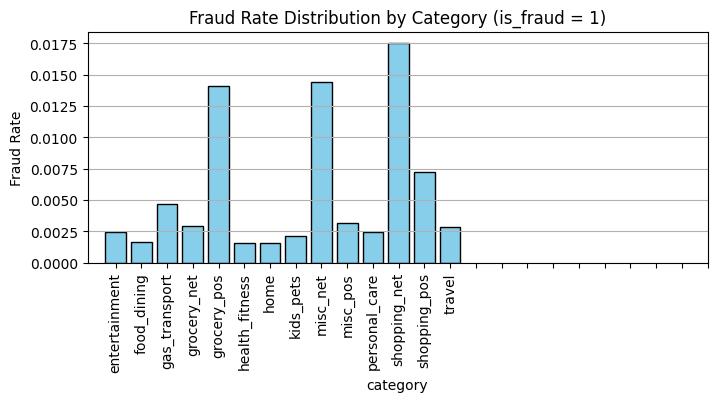

In [26]:
import matplotlib.pyplot as plt

# Plot the fraud rate for each hour
plt.figure(figsize=(8, 3))
plt.bar(category_data['category'], category_data['fraud_rate_by_category'], color='skyblue', edgecolor='black')
plt.title('Fraud Rate Distribution by Category (is_fraud = 1)')
plt.xlabel('category')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24), rotation=90)  # Rotate x-axis labels by 90 degrees
plt.grid(True, axis='y')
plt.show()


In [21]:
unique_categories = df_train['category'].unique()
print(unique_categories)

['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']


## fraud rate by city


In [ ]:
city_data = df_train.groupby('city').agg(
    total_transactions=('city', 'count'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()


city_data['fraud_rate_by_city'] = city_data['fraud_cases'] / city_data['total_transactions']

city_data.sort_values(by=['total_transactions', 'fraud_rate_by_city'], ascending=[True, True])



,city,total_transactions,fraud_cases,fraud_rate_by_city
106,Bruce,7,7,1.000000
138,Chattanooga,7,7,1.000000
151,Claypool,7,7,1.000000
399,Karns City,7,7,1.000000
575,Norfolk,7,7,1.000000
...,...,...,...,...
501,Meridian,5060,13,0.002569
644,Phoenix,5075,2,0.000394
821,Utica,5105,25,0.004897
725,San Antonio,5130,25,0.004873


In [ ]:
# memakai fraud rate untuk city , menyebabkan data jadi kurang tidak berimbang untuk kota kecil ataupun transaksi sedikit
# akan dilakuan mmemasukkan komponen city population dalam  perhitungn

In [ ]:
city_pop_data = df_train.groupby(['city']).agg(
    mean_pop=('city_pop','mean')
).reset_index()
city_pop_data

,city,mean_pop
0,Achille,608.000000
1,Acworth,477.000000
2,Adams,3508.000000
3,Afton,1916.288943
4,Akron,272134.000000
...,...,...
889,Woods Cross,13983.000000
890,Woodville,3395.000000
891,Yellowstone National Park,369.000000
892,Zaleski,341.000000


In [ ]:
print(city_data.columns)
print(city_pop_data.columns)

Index(['city', 'total_transactions', 'fraud_cases', 'fraud_rate_by_city'], dtype='object')
Index(['city', 'mean_pop'], dtype='object')


In [ ]:
#masukkan data populasi rata2 city ke city_data
city_data  = city_data.merge(city_pop_data[['city','mean_pop']], on='city', how='left')

#add scaling untuk populasi
city_data['max_overal_pop']=city_data['mean_pop'].max()
city_data['scaled_pop']=city_data['mean_pop'] / city_data['max_overal_pop']
city_data['fraud_rate_by_city_scaled']=city_data['fraud_rate_by_city'] * city_data['scaled_pop']

city_data.sort_values(by=['total_transactions', 'fraud_rate_by_city_scaled'], ascending=[True, True])

,city,total_transactions,fraud_cases,fraud_rate_by_city,mean_pop,max_overal_pop,scaled_pop,fraud_rate_by_city_scaled
399,Karns City,7,7,1.000000,1.888000e+03,2906700.0,0.000650,6.495338e-04
151,Claypool,7,7,1.000000,3.631000e+03,2906700.0,0.001249,1.249183e-03
106,Bruce,7,7,1.000000,4.046000e+03,2906700.0,0.001392,1.391957e-03
780,Streator,7,7,1.000000,2.013300e+04,2906700.0,0.006926,6.926411e-03
822,Vacaville,7,7,1.000000,9.947500e+04,2906700.0,0.034223,3.422266e-02
...,...,...,...,...,...,...,...,...
501,Meridian,5060,13,0.002569,4.280008e+04,2906700.0,0.014725,3.783007e-05
644,Phoenix,5075,2,0.000394,1.312922e+06,2906700.0,0.451688,1.780052e-04
821,Utica,5105,25,0.004897,5.200725e+02,2906700.0,0.000179,8.762094e-07
725,San Antonio,5130,25,0.004873,1.595797e+06,2906700.0,0.549006,2.675470e-03


In [ ]:
city_data.describe()

,total_transactions,fraud_cases,fraud_rate_by_city,mean_pop,max_overal_pop,scaled_pop,fraud_rate_by_city_scaled
count,894.000000,894.000000,894.000000,8.940000e+02,894.0,894.000000,8.940000e+02
mean,1450.419463,8.395973,0.071647,6.282816e+04,2906700.0,0.021615,1.569622e-03
std,943.703719,5.782917,0.244757,2.332560e+05,0.0,0.080248,1.943300e-02
min,7.000000,0.000000,0.000000,2.300000e+01,2906700.0,0.000008,0.000000e+00
25%,533.000000,5.000000,0.002574,7.820000e+02,2906700.0,0.000269,3.335295e-07
50%,1513.000000,9.000000,0.006263,2.676000e+03,2906700.0,0.000921,3.668555e-06
75%,2045.000000,12.000000,0.011479,1.603400e+04,2906700.0,0.005516,3.434531e-05
max,5617.000000,39.000000,1.000000,2.906700e+06,2906700.0,1.000000,4.877672e-01


In [ ]:
df_train = df_train.merge(city_data[['city', 'fraud_rate_by_city_scaled']], on='city', how='left')
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_hour,unix_dow,dow_dif,card_merchant_distance_km,card_merchant_distance_km_grp,person_age,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,0,6,2,78.597568,70.0,37,30,0.014940,0.014458,0.000000e+00
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,0,6,2,30.212176,30.0,47,40,0.014940,0.014098,0.000000e+00
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,0,6,2,108.206083,100.0,63,60,0.014940,0.002478,0.000000e+00
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,0,6,2,95.673231,90.0,58,50,0.014940,0.004694,2.029654e-05
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,0,6,2,77.556744,70.0,39,30,0.014940,0.003139,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,12,4,2,119.752136,110.0,66,60,0.001027,0.002478,5.279868e-07
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,12,4,2,75.104085,70.0,48,40,0.001027,0.001651,5.183168e-07
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,12,4,2,99.047734,90.0,60,60,0.001027,0.001651,1.643546e-06
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,12,4,2,84.627652,80.0,47,40,0.001027,0.001651,1.531150e-06


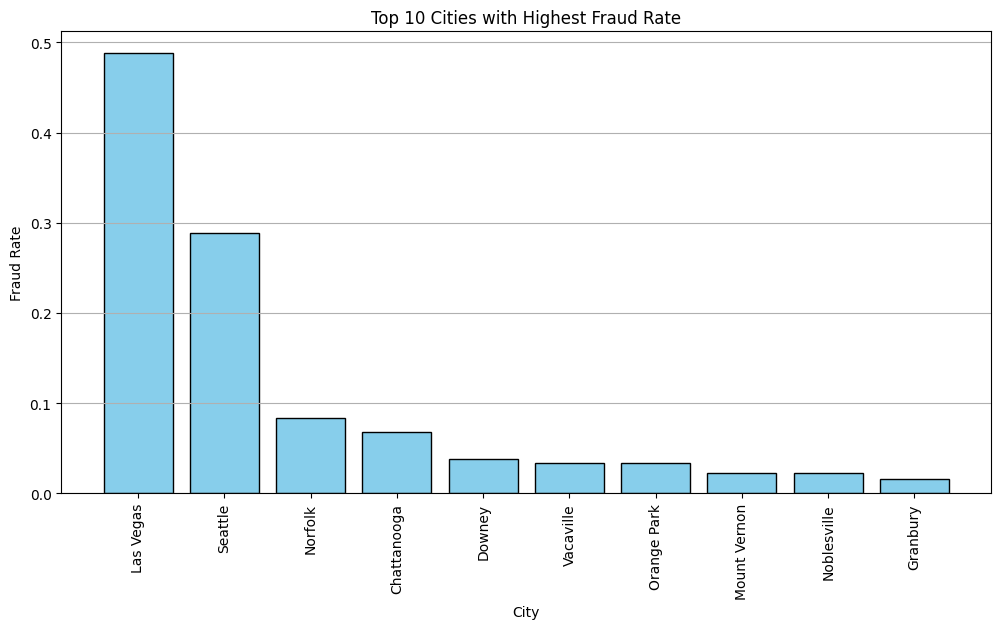

In [ ]:
import matplotlib.pyplot as plt

# Get the top jmlnya states with the highest fraud rate
jmlnya = 10
top_rate_cities = df_train.groupby('city')['fraud_rate_by_city_scaled'].mean().sort_values(ascending=False).head(jmlnya)

# Plot the fraud rate for the top jmlnya cities
plt.figure(figsize=(12, 6))
plt.bar(top_rate_cities.index, top_rate_cities.values, color='skyblue', edgecolor='black')
plt.title('Top 10 Cities with Highest Fraud Rate')
plt.xlabel('City')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.grid(True, axis='y')
plt.show()


In [ ]:
#tukang stop proses jupyter , uncomment to break the running process of "Run All" 


In [ ]:
category_stats = df_train.groupby('category')['amt'].describe(percentiles=[.05, .95])
category_stats = category_stats.rename(columns={'5%': 'cat_amt_5pctl', '95%': 'cat_amt_95pctl'})
category_stats

,count,mean,std,min,cat_amt_5pctl,50%,cat_amt_95pctl,max
category,,,,,,,,
entertainment,94014.0,64.210421,66.181129,1.00,3.17,50.740,183.4480,934.47
food_dining,91461.0,51.086905,48.854164,1.00,2.47,42.030,143.6700,769.26
gas_transport,131659.0,63.434572,15.886738,5.93,39.29,62.840,90.7100,154.03
grocery_net,45452.0,53.670084,22.544396,1.44,20.74,50.920,95.9135,185.81
grocery_pos,123638.0,116.960986,53.214365,10.87,47.38,105.120,215.6900,397.97
health_fitness,85879.0,54.182140,48.593696,1.00,3.69,42.850,147.1800,598.38
home,123115.0,58.270139,48.681218,1.00,4.88,48.290,150.5330,560.81
kids_pets,113035.0,57.536871,48.722021,1.00,5.12,47.180,153.9100,586.34
misc_net,63287.0,80.865095,166.860495,1.00,1.60,9.840,383.2110,4084.34


## flagging outlier untuk Category VS Amount

In [ ]:
#join ke df_train
df_train= df_train.merge(category_stats[['cat_amt_5pctl','cat_amt_95pctl']], on='category', how = 'left')
df_train['category_lower_outlier']=np.where(df_train['amt'] < df_train['cat_amt_5pctl'],1,0)
df_train['category_upper_outlier']=np.where(df_train['amt'] > df_train['cat_amt_95pctl'],1,0)
#drop kolom bantuan 
df_train=df_train.drop('cat_amt_5pctl', axis=1)
df_train=df_train.drop('cat_amt_95pctl', axis=1)

df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dow_dif,card_merchant_distance_km,card_merchant_distance_km_grp,person_age,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled,category_lower_outlier,category_upper_outlier
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,2,78.597568,70.0,37,30,0.014940,0.014458,0.000000e+00,0,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,2,30.212176,30.0,47,40,0.014940,0.014098,0.000000e+00,0,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,2,108.206083,100.0,63,60,0.014940,0.002478,0.000000e+00,0,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,2,95.673231,90.0,58,50,0.014940,0.004694,2.029654e-05,0,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,2,77.556744,70.0,39,30,0.014940,0.003139,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,2,119.752136,110.0,66,60,0.001027,0.002478,5.279868e-07,0,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,2,75.104085,70.0,48,40,0.001027,0.001651,5.183168e-07,0,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,2,99.047734,90.0,60,60,0.001027,0.001651,1.643546e-06,0,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,2,84.627652,80.0,47,40,0.001027,0.001651,1.531150e-06,0,0


In [ ]:
job_stats = df_train.groupby('job')['amt'].describe(percentiles=[.05, .95])
job_stats = job_stats.rename(columns={'5%': 'job_amt_5pctl', '95%': 'job_amt_95pctl'})
job_stats

,count,mean,std,min,job_amt_5pctl,50%,job_amt_95pctl,max
job,,,,,,,,
Academic librarian,1041.0,69.623641,275.684263,1.01,2.3600,35.670,173.8900,8059.02
"Accountant, chartered",11.0,485.706364,384.056433,7.84,8.8400,318.870,1033.0300,1063.77
"Accountant, chartered certified",534.0,72.945112,120.996626,1.16,2.6595,52.160,193.4360,1150.64
"Accountant, chartered public finance",2580.0,54.839640,103.992162,1.01,2.0595,32.920,149.2630,1658.03
Accounting technician,4673.0,77.004684,145.725312,1.02,2.8860,60.250,161.9960,6527.88
...,...,...,...,...,...,...,...,...
Water engineer,6164.0,70.825936,154.715403,1.01,2.2915,42.735,212.5995,8217.23
Water quality scientist,510.0,72.321176,220.264433,1.01,2.1975,37.315,199.4285,4090.62
Web designer,2556.0,62.053376,121.291938,1.01,2.0800,35.920,159.5025,2135.91


## flagging outlier untuk Job VS Amount

In [ ]:
#join ke df_train
df_train= df_train.merge(job_stats[['job_amt_5pctl','job_amt_95pctl']], on='job', how = 'left')
df_train['job_lower_outlier']=np.where(df_train['amt'] < df_train['job_amt_5pctl'],1,0)
df_train['job_upper_outlier']=np.where(df_train['amt'] > df_train['job_amt_95pctl'],1,0)
#drop kolom bantuan 
df_train=df_train.drop('job_amt_5pctl', axis=1)
df_train=df_train.drop('job_amt_95pctl', axis=1)
df_train

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,card_merchant_distance_km_grp,person_age,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled,category_lower_outlier,category_upper_outlier,job_lower_outlier,job_upper_outlier
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,70.0,37,30,0.014940,0.014458,0.000000e+00,0,0,0,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,30.0,47,40,0.014940,0.014098,0.000000e+00,0,0,0,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,100.0,63,60,0.014940,0.002478,0.000000e+00,0,1,0,1
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,90.0,58,50,0.014940,0.004694,2.029654e-05,0,0,0,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,70.0,39,30,0.014940,0.003139,0.000000e+00,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,110.0,66,60,0.001027,0.002478,5.279868e-07,0,0,0,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,70.0,48,40,0.001027,0.001651,5.183168e-07,0,0,0,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,90.0,60,60,0.001027,0.001651,1.643546e-06,0,0,0,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,80.0,47,40,0.001027,0.001651,1.531150e-06,0,0,0,0


TO DO yang belon dikerjakan untuk EDA di atas:

- apa perlu flagging highrisk juga semacam jarak vs isFraud == 1 ?  >>>>> DONE di bawah
- apa perlu flagging highrisk juga semacam umur vs isFraud == 1 ?  >>>>> DONE di bawah
- apa perlu flagging highrisk juga semacam trxtime_bookingtime_diff vs isFraud == 1 ?  >>>>> DONE di bawah

- CC usage count ( kecil2 tapi banyak atau sekali tapi langsung big amount) ---- gimana cara modeling data / chart nya ? (mungkin bisa pakai cummulative trx count dan avarage amount per CC per bulan bersangkutan ?) >>>>> SKIP gak ada waktu

## fraud rate by umur group

In [ ]:
# menerapkan cara kerja yang sama, dengan "fraud rate by unix_hour"
# comment lebih lengkap ada di sana

umur_data = df_train.groupby('person_age_grp').agg(
    total_transactions=('is_fraud', 'size'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()

umur_data['fraud_rate_by_umur'] = umur_data['fraud_cases'] / umur_data['total_transactions']

df_train = df_train.merge(umur_data[['person_age_grp', 'fraud_rate_by_umur']], on='person_age_grp', how='left')

df_train.sample(10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,person_age,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled,category_lower_outlier,category_upper_outlier,job_lower_outlier,job_upper_outlier,fraud_rate_by_umur
162048,162048,2019-03-26 23:37:30,213174467670432,fraud_Johnston-Casper,travel,1.76,James,Bishop,M,7055 Fernandez Estates Apt. 676,...,57,50,0.028374,0.002864,2.239140e-06,0,0,1,0,0.005093
840615,840615,2019-12-13 19:00:14,501802953619,fraud_Cummerata-Hilpert,entertainment,55.46,Robert,Flores,M,3277 Fields Meadows Apt. 790,...,68,60,0.001236,0.002478,4.757759e-07,0,0,0,0,0.007880
694504,694504,2019-10-23 12:42:46,4708992452821239,"fraud_Conroy, Balistreri and Gorczany",health_fitness,23.67,Jared,Walters,M,3326 Hannah Fords,...,88,80,0.001027,0.001549,0.000000e+00,0,0,0,0,0.008673
1117514,1117514,2020-04-10 08:52:44,4195740185974,"fraud_Connelly, Reichert and Fritsch",gas_transport,64.59,Benjamin,Robinson,M,0701 John Ranch,...,64,60,0.001153,0.004694,0.000000e+00,0,0,0,0,0.007880
161392,161392,2019-03-26 14:28:25,6011934240159560,fraud_Feil-Morar,health_fitness,74.45,Joshua,Cohen,M,426 Mark Ports,...,52,50,0.001325,0.001549,2.795690e-06,0,0,0,0,0.005093
84945,84945,2019-02-19 12:57:07,4681699462969,fraud_Thiel-Thiel,entertainment,117.99,Joseph,Gonzalez,M,319 Wendy Fort Suite 179,...,48,40,0.001027,0.002478,1.483651e-04,0,0,0,0,0.004226
639328,639328,2019-09-29 09:29:03,373905417449658,fraud_Bruen-Yost,misc_pos,90.16,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,...,56,50,0.001114,0.003139,3.783007e-05,0,0,0,0,0.005093
190444,190444,2019-04-08 11:14:01,6592243974328236,fraud_Cummerata-Jones,gas_transport,49.98,Philip,Hart,M,97405 Vazquez Plains,...,32,30,0.000998,0.004694,5.109230e-04,0,0,0,0,0.005317
804408,804408,2019-12-05 14:02:56,4800395067176717,fraud_Dare-Marvin,entertainment,30.72,Daniel,Owens,M,88794 Mandy Lodge Apt. 874,...,98,90,0.001325,0.002478,2.607113e-06,0,0,0,0,0.008588
137779,137779,2019-03-16 18:24:25,6506116513503136,"fraud_Schneider, Hayes and Nikolaus",food_dining,58.72,Kimberly,Rice,F,63991 Destiny Rue Apt. 651,...,42,40,0.001226,0.001651,3.539184e-04,0,0,0,0,0.004226


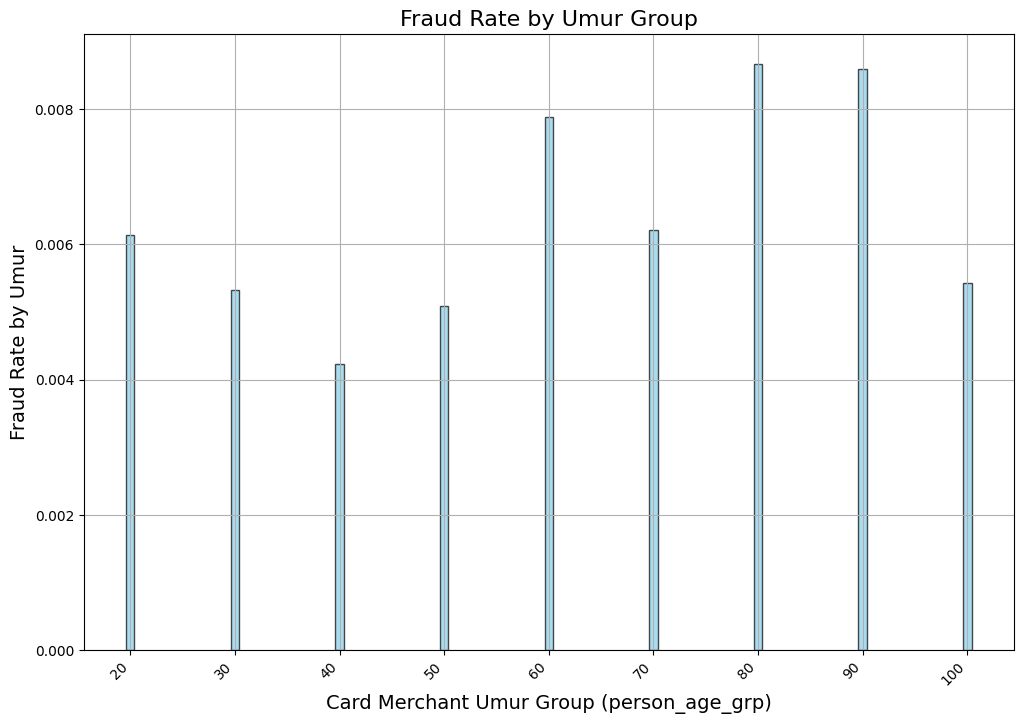

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(umur_data['person_age_grp'], umur_data['fraud_rate_by_umur'], color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Fraud Rate by Umur Group', fontsize=16)
plt.xlabel('Card Merchant Umur Group (person_age_grp)', fontsize=14)
plt.ylabel('Fraud Rate by Umur', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.grid(True)

plt.show()

## fraud rate by jarak group

In [ ]:
# menerapkan cara kerja yang sama, dengan "fraud rate by unix_hour"
# comment lebih lengkap ada di sana

distance_data = df_train.groupby('card_merchant_distance_km_grp').agg(
    total_transactions=('is_fraud', 'size'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()

distance_data['fraud_rate_by_distance'] = distance_data['fraud_cases'] / distance_data['total_transactions']

df_train = df_train.merge(distance_data[['card_merchant_distance_km_grp', 'fraud_rate_by_distance']], on='card_merchant_distance_km_grp', how='left')

df_train.sample(10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,person_age_grp,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled,category_lower_outlier,category_upper_outlier,job_lower_outlier,job_upper_outlier,fraud_rate_by_umur,fraud_rate_by_distance
715918,715918,2019-11-02 08:02:17,3582754887089201,fraud_Rodriguez Group,gas_transport,67.56,Terrance,Mckinney,M,42965 Christopher Fords Suite 659,...,60,0.001153,0.004694,2.035329e-06,0,0,0,0,0.007880,0.005736
1258860,1258860,2020-06-08 00:27:56,378006354724784,fraud_Vandervort-Funk,grocery_pos,93.36,Christopher,Matthews,M,433 John Heights Apt. 849,...,40,0.014940,0.014098,0.000000e+00,0,0,0,0,0.004226,0.005686
844751,844751,2019-12-14 16:14:52,213156747557083,fraud_Rolfson-Kunde,personal_care,51.26,Adam,Santos,M,725 Jo Trace Apt. 102,...,40,0.001156,0.002424,2.501920e-04,0,0,0,0,0.004226,0.005317
273669,273669,2019-05-15 13:44:36,4158945090781624,fraud_Shields-Wunsch,health_fitness,62.04,Justin,Bell,M,5323 Walker Island,...,50,0.001225,0.001549,0.000000e+00,0,0,0,0,0.005093,0.006071
28519,28519,2019-01-17 17:27:33,3525668150756629,fraud_Ullrich Ltd,kids_pets,50.14,Christopher,Choi,M,04611 Sandra Spring Suite 059,...,30,0.001192,0.002114,5.018948e-07,0,0,0,0,0.005317,0.006071
543053,543053,2019-08-20 13:44:02,4302480582202074,"fraud_Hermiston, Pacocha and Smith",health_fitness,118.42,David,Rodriguez,M,821 Solis Points,...,30,0.001225,0.001549,2.076538e-04,0,0,0,0,0.005317,0.005881
386757,386757,2019-06-26 11:12:54,3514897282719543,fraud_Dooley-Thompson,misc_net,8.42,Steven,Faulkner,M,841 Cheryl Centers Suite 115,...,70,0.000998,0.014458,0.000000e+00,0,0,0,0,0.006218,0.005828
32282,32282,2019-01-20 09:19:55,36913587729122,fraud_Emard Inc,gas_transport,55.33,Ana,Mccormick,F,4503 Patricia Route,...,50,0.001114,0.004694,3.783007e-05,0,0,0,0,0.005093,0.005777
600259,600259,2019-09-12 03:42:16,4344955088481397,"fraud_Streich, Dietrich and Barton",shopping_net,91.76,Christopher,Rodgers,M,30587 Fox Shores Apt. 627,...,50,0.014239,0.017561,5.817134e-06,0,0,0,0,0.005093,0.005710
29188,29188,2019-01-18 05:56:01,4908846471916297,fraud_Deckow-O'Conner,grocery_pos,198.79,Lauren,Torres,F,03030 White Lakes,...,30,0.001423,0.014098,1.995254e-06,0,0,0,0,0.005317,0.005828


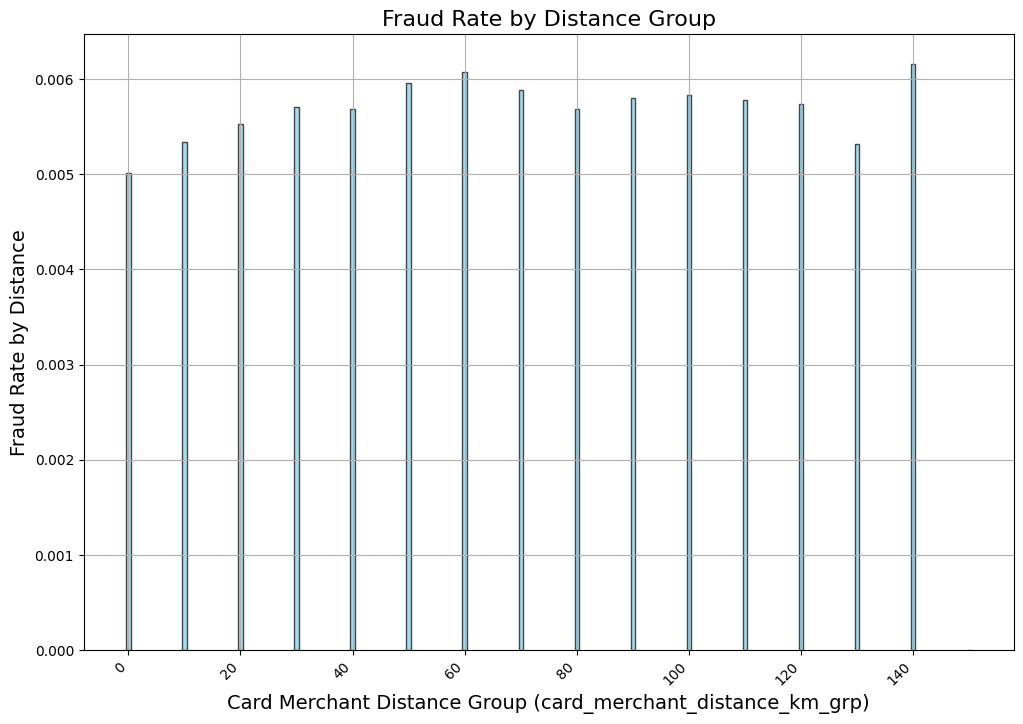

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(distance_data['card_merchant_distance_km_grp'], distance_data['fraud_rate_by_distance'], color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Fraud Rate by Distance Group', fontsize=16)
plt.xlabel('Card Merchant Distance Group (card_merchant_distance_km_grp)', fontsize=14)
plt.ylabel('Fraud Rate by Distance', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.grid(True)

plt.show()

## fraud rate by dow_diff (selisih transaksi vs  pembukuan)

In [ ]:
# menerapkan cara kerja yang sama, dengan "fraud rate by unix_hour"
# comment lebih lengkap ada di sana

day_diff_data = df_train.groupby('dow_dif').agg(
    total_transactions=('is_fraud', 'size'),
    fraud_cases=('is_fraud', 'sum')
).reset_index()

day_diff_data['fraud_rate_by_dow_diff'] = day_diff_data['fraud_cases'] / day_diff_data['total_transactions']

df_train = df_train.merge(day_diff_data[['dow_dif', 'fraud_rate_by_dow_diff']], on='dow_dif', how='left')

df_train.sample(10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,fraud_rate_by_unix_hour,fraud_rate_by_category,fraud_rate_by_city_scaled,category_lower_outlier,category_upper_outlier,job_lower_outlier,job_upper_outlier,fraud_rate_by_umur,fraud_rate_by_distance,fraud_rate_by_dow_diff
327741,327741,2019-06-05 12:43:11,3524574586339330,fraud_Weimann-Lockman,kids_pets,117.95,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,...,0.001027,0.002114,7.020528e-05,0,0,0,0,0.004226,0.006163,0.005298
1086360,1086360,2020-03-27 18:26:24,4764202053279782,"fraud_Douglas, Schneider and Turner",shopping_pos,9.93,Derek,Jones,M,198 Candace Plaza,...,0.001226,0.007225,3.576967e-06,0,0,0,0,0.004226,0.005801,0.007007
1146942,1146942,2020-04-22 22:18:10,3513618443244549,"fraud_McCullough, Hudson and Schuster",food_dining,1.62,Amber,Perez,F,954 Reyes Ways,...,0.028829,0.001651,2.965568e-07,1,0,1,0,0.006218,0.005777,0.007007
189166,189166,2019-04-07 23:31:07,180014262259255,fraud_Lemke and Sons,travel,9.99,Brianna,Page,F,0043 Henry Plaza,...,0.028374,0.002864,1.039593e-05,0,0,0,0,0.007880,0.005881,0.005298
55486,55486,2019-02-03 00:02:37,630484879808,"fraud_Langworth, Boehm and Gulgowski",shopping_net,102.94,Ian,Patton,M,8088 Sherman Radial Suite 689,...,0.014940,0.017561,1.690106e-07,0,0,0,0,0.005093,0.005736,0.007007
490429,490429,2019-08-02 16:50:31,373905417449658,fraud_Bogisich-Weimann,kids_pets,32.84,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,...,0.001156,0.002114,3.783007e-05,0,0,0,0,0.005093,0.005777,0.005298
836875,836875,2019-12-12 18:56:06,4181833256558613886,fraud_Haley Group,misc_pos,31.45,Jessica,Potter,F,7600 Stephen Course Suite 031,...,0.001226,0.003139,1.132185e-06,0,0,0,0,0.005317,0.005801,0.005298
399991,399991,2019-06-30 23:56:58,4755696071492,fraud_Kassulke Inc,entertainment,16.91,Robert,Evans,M,01892 Patricia Vista Apt. 828,...,0.028374,0.002478,0.000000e+00,0,0,0,0,0.004226,0.006071,0.005298
228377,228377,2019-04-25 17:10:16,373905417449658,fraud_Wilkinson LLC,personal_care,20.88,Sarah,Bishop,F,554 Mcdonald Valley Apt. 539,...,0.001192,0.002424,3.783007e-05,0,0,0,0,0.005093,0.005881,0.005298
257381,257381,2019-05-08 06:09:15,676173792455,fraud_Harris Inc,gas_transport,77.77,Brittany,Cox,F,07177 William Dale Apt. 547,...,0.000946,0.004694,0.000000e+00,0,0,0,0,0.007880,0.005710,0.005298


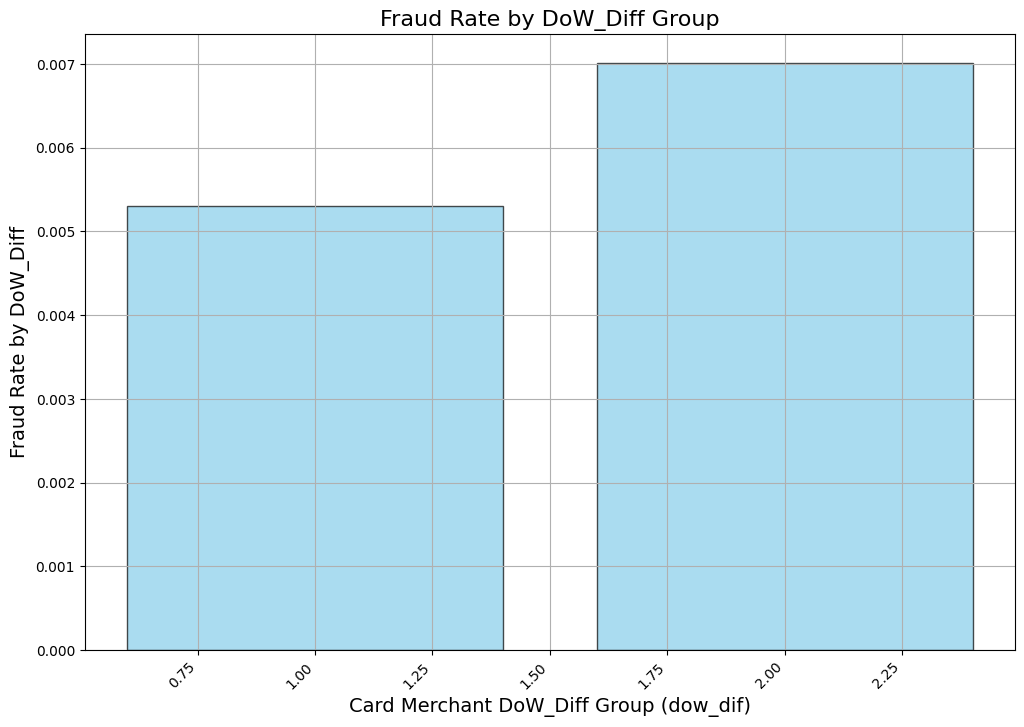

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(day_diff_data['dow_dif'], day_diff_data['fraud_rate_by_dow_diff'], color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Fraud Rate by DoW_Diff Group', fontsize=16)
plt.xlabel('Card Merchant DoW_Diff Group (dow_dif)', fontsize=14)
plt.ylabel('Fraud Rate by DoW_Diff', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.grid(True)

plt.show()

## dummy var untuk Gender

In [ ]:

df_train = df_train.copy(deep=True)

#KARENA SUDAH PAKAI FLAGGING 'risk_level_of_category' , tidak perlu dijadikan variable dummy (label encoding ataupun OHE)
    # #copy data dulu untuk keperluan EDA (e.g. check missng value, etc)
    # df_train['category_ori'] = df_train['category']
    # #membuath dummy variable (OHE)
    # df_train = pd.get_dummies(df_train, columns=['category'], drop_first=True)


#copy data dulu untuk keperluan EDA (e.g. check missng value, etc)
# df_train['gender_ori'] = df_train['gender']

#membuath dummy variable (OHE)
df_train = pd.get_dummies(df_train, columns=['gender'], drop_first=True)

# df_train.sample(5)
# df_train.sample(30).to_csv('df_train_encoded_sample.csv', index=False)

In [ ]:
df_train.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long',
       'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_year', 'trans_month', 'trans_date',
       'trans_hour', 'trans_dow', 'unix_year', 'unix_month', 'unix_date',
       'unix_hour', 'unix_dow', 'dow_dif', 'card_merchant_distance_km',
       'card_merchant_distance_km_grp', 'person_age', 'person_age_grp',
       'fraud_rate_by_unix_hour', 'fraud_rate_by_category',
       'fraud_rate_by_city_scaled', 'category_lower_outlier',
       'category_upper_outlier', 'job_lower_outlier', 'job_upper_outlier',
       'fraud_rate_by_umur', 'fraud_rate_by_distance',
       'fraud_rate_by_dow_diff', 'gender_M'],
      dtype='object')

In [ ]:
mini_eda(df_train, 'eda_report__df_train_withDummies.pdf')

In [ ]:
# tukang stop proses jupyter , uncomment to break the running process of "Run All" 

In [ ]:
# tukang stop proses jupyter , uncomment to break the running process of "Run All" 

# SPLIT

In [ ]:
#split antara feature dan target 

X = df_train.drop('is_fraud', axis=1)
y = df_train['is_fraud']


# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split training data into training and validation sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# X_train dan y_train digabung lagi dulu karen akan dilakukan handling imbalance data 
df_train_8080 = pd.concat([X_train, y_train], axis=1)
df_val_8020 = pd.concat([X_val, y_val], axis=1)
df_test_20 = pd.concat([X_test, y_test], axis=1)

# Optionally, check the shape of the split data
print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")


Training features shape: (829872, 47)
Validation features shape: (207468, 47)
Test features shape: (259335, 47)


## Handling Imbalanced Data

In [ ]:

target_distribution = df_train_8080['is_fraud'].value_counts()
print(target_distribution)
print('-------------------')
print(target_distribution / target_distribution.sum() * 100)
print('-------------------')

fraud_cases = target_distribution[1]  
non_fraud_cases = target_distribution[0]  
imbalance_ratio = non_fraud_cases / fraud_cases
print(f"Imbalance ratio (Non-fraud / Fraud): {imbalance_ratio:.2f}")
print('-------------------')


0    825121
1      4751
Name: is_fraud, dtype: int64
-------------------
0    99.427502
1     0.572498
Name: is_fraud, dtype: float64
-------------------
Imbalance ratio (Non-fraud / Fraud): 173.67
-------------------


In [ ]:
#install dulu kalau belum ada di env kita
#!pip install imbalanced-learn

In [ ]:
df_train_8080.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'street', 'city', 'state', 'zip', 'lat', 'long',
       'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'trans_year', 'trans_month', 'trans_date', 'trans_hour',
       'trans_dow', 'unix_year', 'unix_month', 'unix_date', 'unix_hour',
       'unix_dow', 'dow_dif', 'card_merchant_distance_km',
       'card_merchant_distance_km_grp', 'person_age', 'person_age_grp',
       'fraud_rate_by_unix_hour', 'fraud_rate_by_category',
       'fraud_rate_by_city_scaled', 'category_lower_outlier',
       'category_upper_outlier', 'job_lower_outlier', 'job_upper_outlier',
       'fraud_rate_by_umur', 'fraud_rate_by_distance',
       'fraud_rate_by_dow_diff', 'gender_M', 'is_fraud'],
      dtype='object')

## Correlation Map

C:\Users\andyp\AppData\Local\Temp\ipykernel_9796\2448227735.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train_8080.corr()


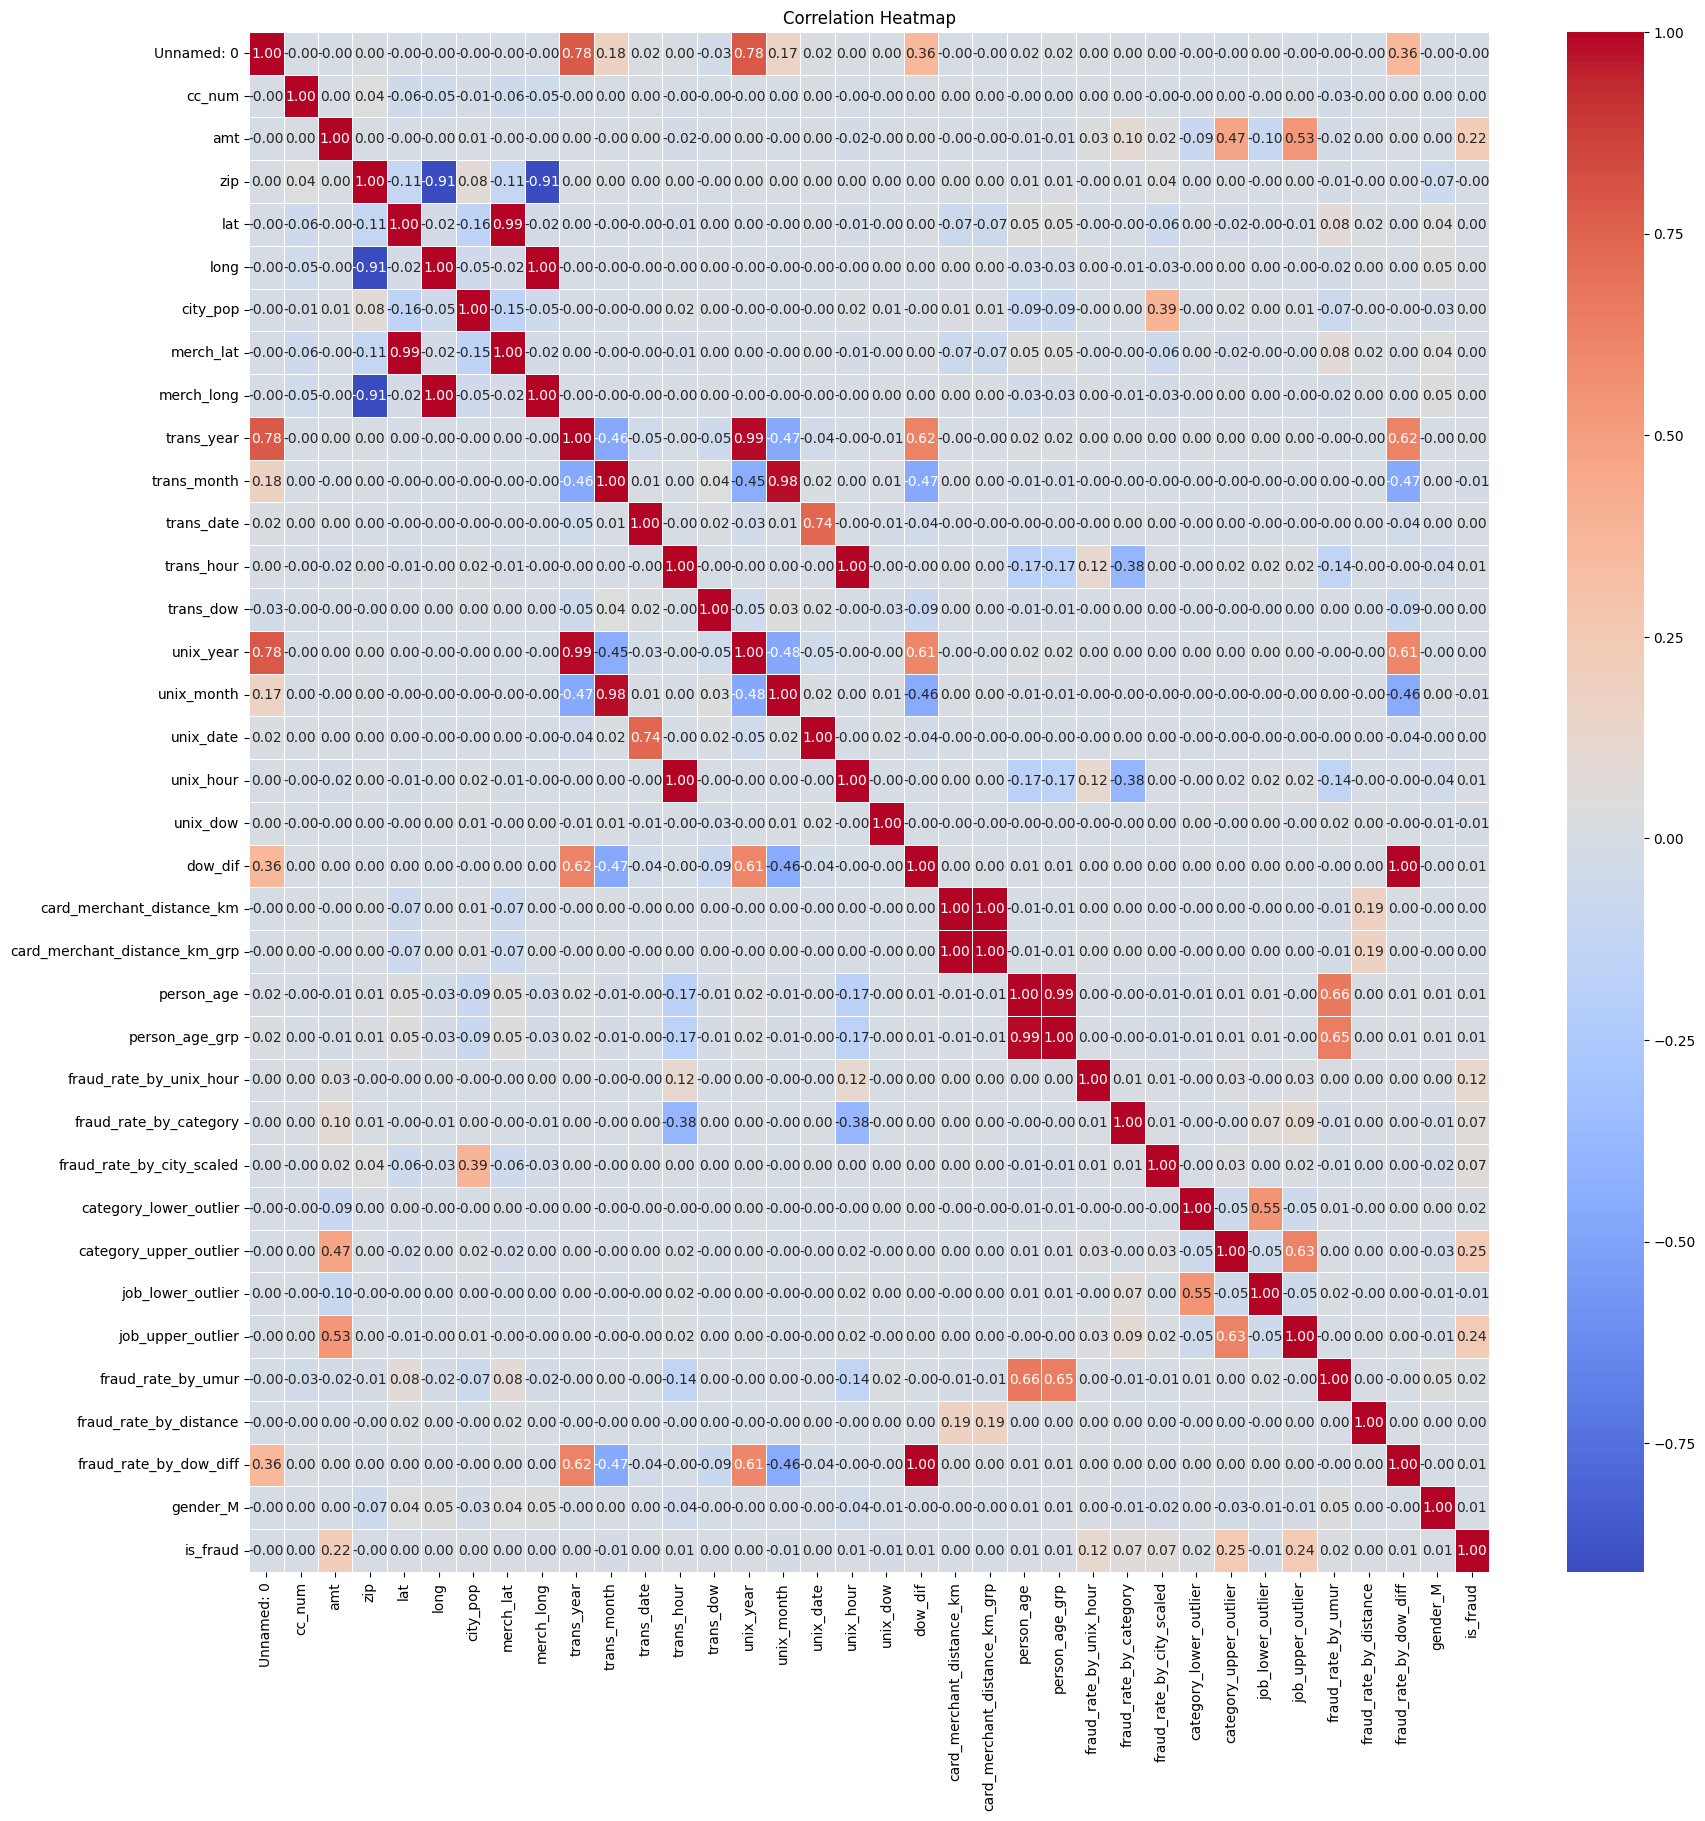

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_train_8080.corr()

# Plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#memilih feature secara manual utuk feature2 yang 

list_of_selected_field=[
# 'Unnamed:0',
# 'trans_date_trans_time',
# 'cc_num',
# 'merchant',
# 'category',
'amt',
# 'first',
# 'last',
# 'street',
# 'city',
# 'state',
# 'zip',
# 'lat',
# 'long',
'city_pop',
# 'job',
# 'dob',
# 'trans_num',
# 'unix_time',
# 'merch_lat',
# 'merch_long',
'is_fraud',
# 'trans_year',
# 'trans_month',
# 'trans_date',
# 'trans_hour',
# 'trans_dow',
'unix_year',
'unix_month',
'unix_date',
'unix_hour',
'unix_dow',
'dow_dif',
# 'card_merchant_distance_km',
'card_merchant_distance_km_grp',
# 'person_age',
'person_age_grp',
'fraud_rate_by_unix_hour',
'fraud_rate_by_category',
'fraud_rate_by_city_scaled',
'category_lower_outlier',
'category_upper_outlier',
'job_lower_outlier',
'job_upper_outlier',
'fraud_rate_by_umur',
'fraud_rate_by_distance',
'fraud_rate_by_dow_diff',
'gender_M'
]

## Splitted Data and Selected Features

In [ ]:
df_train_8080_selected = df_train_8080[list_of_selected_field]
df_val_8020_selected = df_val_8020[list_of_selected_field]
df_test_20_selected= df_test_20[list_of_selected_field]

### melihat correlation map untuk data training yang featurenya sudah dipilih

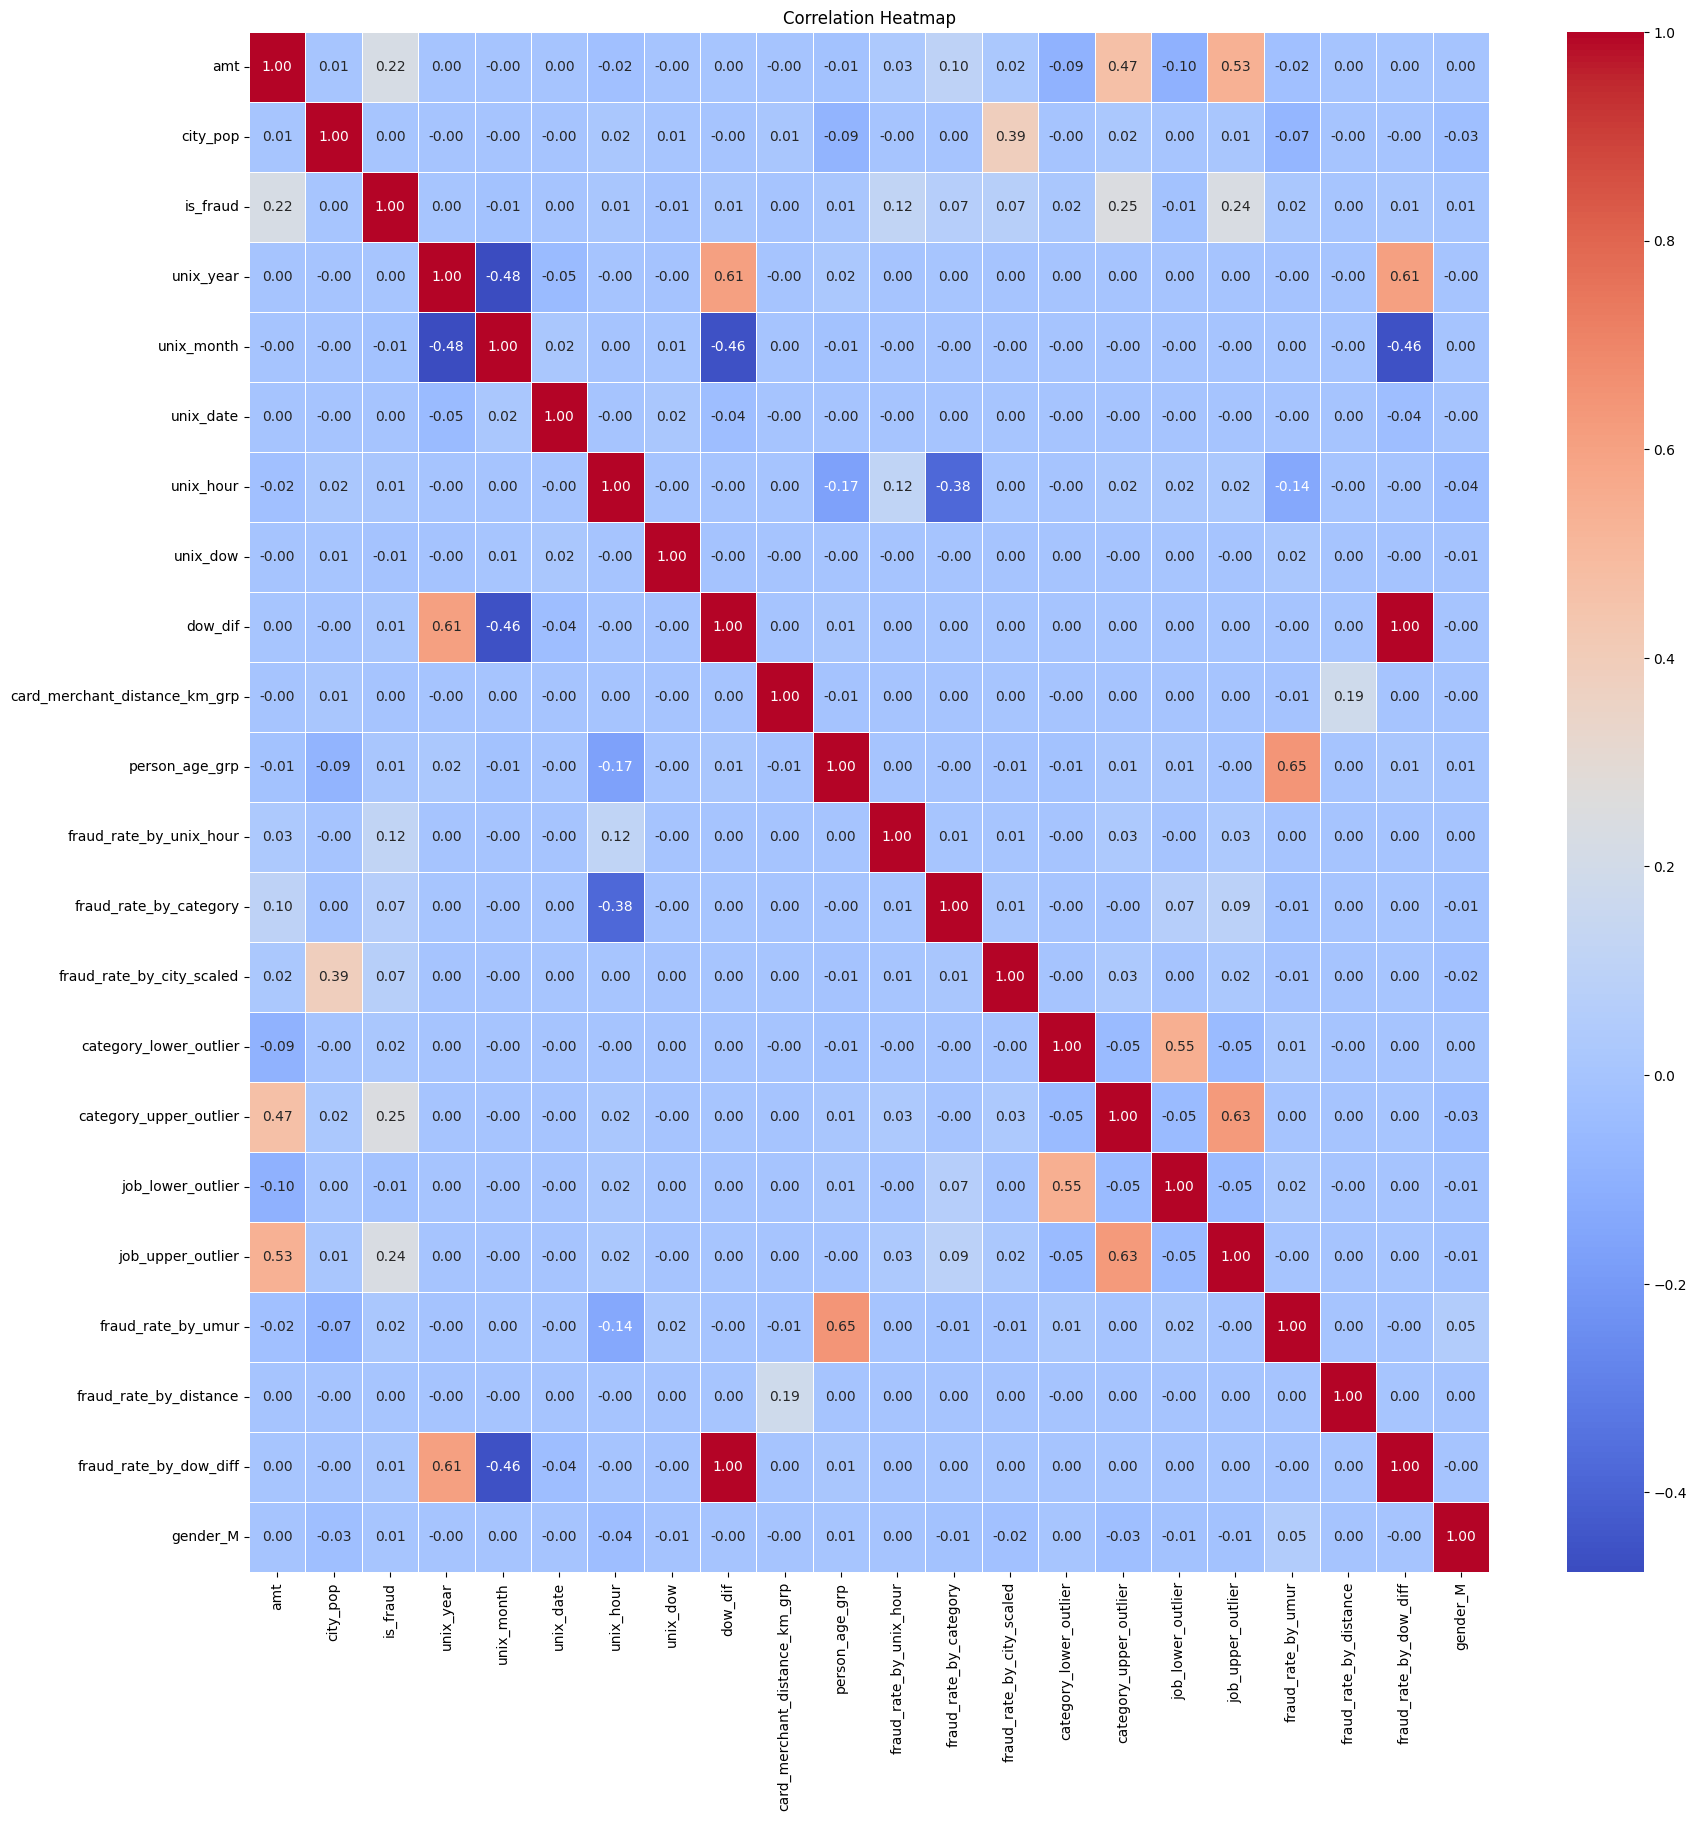

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df_train_8080_selected.corr()

# Plot the heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X = df_train_8080_selected.drop('is_fraud', axis=1)
y = df_train_8080_selected['is_fraud']

smote = SMOTE(random_state=42)
X_smoted, y_smoted = smote.fit_resample(X, y)

df_train_balanced_smote = pd.DataFrame(X_smoted, columns=X.columns)
df_train_balanced_smote['is_fraud'] = y_smoted


In [ ]:
target_distribution = df_train_balanced_smote['is_fraud'].value_counts()
print(target_distribution)
print('-------------------')
print(target_distribution / target_distribution.sum() * 100)
print('-------------------')

fraud_cases = target_distribution[1]  
non_fraud_cases = target_distribution[0]  
imbalance_ratio = non_fraud_cases / fraud_cases
print(f"Imbalance ratio (Non-fraud / Fraud): {imbalance_ratio:.2f}")
print('-------------------')

0    825121
1    825121
Name: is_fraud, dtype: int64
-------------------
0    50.0
1    50.0
Name: is_fraud, dtype: float64
-------------------
Imbalance ratio (Non-fraud / Fraud): 1.00
-------------------


====================================================================<br>
disini data sudah di split dan sudah dipilih beberapa feature yang akan dipakai (manual)<br>
tinggal memilih model yang ingin dipkai<br>
====================================================================<br>
data yang siap digunakan :<br>
- df_train_balanced_smote : untuk data training
- df_val_8020_selected  : untuk data validasi
- df_test_20_selected : untuk data test


# ADABOOST MODELING

## Define Adaboost Model

In [ ]:
#
base_estimator = RandomForestClassifier() # tidak ada parameter di set , saya ambil default saja semua 

# Initialize AdaBoost with base estimator and n_estimators (number of trees)
model = AdaBoostClassifier(
        estimator=base_estimator, 
        n_estimators=100, 
        random_state=42)


## Model Fitting

### Akan Fitting Model, [AWAS LAMA!!!!!]

 skip saja kalau udah pernah , langsung load saja di bawah

In [ ]:
X = df_train_balanced_smote.drop('is_fraud', axis=1)
y = df_train_balanced_smote['is_fraud']

In [ ]:
model.fit(X, y)

AdaBoostClassifier(estimator=RandomForestClassifier(), n_estimators=100,
                   random_state=42)

### Save/Load Model to/from File (bisa di skip kalau tidak perlu)

In [ ]:
#save modelnya dulu 
nama_filenya = 'model_adaboost_RandomForestClassifier_n100.pkl'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

nama_filenya = nama_filenya.replace('.pkl', f'_{timestamp}.pkl')
save_model_to_pickle(model,nama_filenya)

Model saved to model_adaboost_RandomForestClassifier_n100_20250227_0833.pkl


In [ ]:
# #load modelnya 
# nama_filenya = 'model_adaboost_RandomForestClassifier_n100_20250227_0613.pkl' #<<< ganti nama file nya sesuai dengan model yang ingin di load
model = load_model_from_pickle(nama_filenya)

Model loaded from model_adaboost_RandomForestClassifier_n100_20250227_0833.pkl


## Checking Feature Importance

In [ ]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [ ]:
feature_importance_df

,Feature,Importance
10,fraud_rate_by_unix_hour,0.305083
0,amt,0.221119
14,category_upper_outlier,0.119100
11,fraud_rate_by_category,0.087417
16,job_upper_outlier,0.085669
5,unix_hour,0.044706
19,fraud_rate_by_dow_diff,0.017821
12,fraud_rate_by_city_scaled,0.017639
17,fraud_rate_by_umur,0.015927
1,city_pop,0.012413


dari feature importance di atas, kita akan coba ambil lagi natni buat model ke 2 yang menggunakan feature2 yang importancenya 1% ke atas

## Predict Validation Data

In [ ]:
X_val = df_val_8020_selected.drop('is_fraud', axis=1)
y_val = df_val_8020_selected['is_fraud']

# Predict on the test set
y_pred = model.predict(X_val)

# Predict probabilities for ROC-AUC evaluation
y_pred_prob = model.predict_proba(X_val)[:, 1]

## Evaluate Predicted Validation Data

In [ ]:
# Print classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_val, y_pred))
print('---------------------------------------------------')
# Confusion matrix to understand true positives, false positives, etc.
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Non-Fraud', 'Actual Fraud'], columns=['Predicted Non-Fraud', 'Predicted Fraud'])
print("Confusion Matrix:\n", cm_df )
print('---------------------------------------------------')
# Calculate ROC-AUC score for model's ability to distinguish between classes
roc_auc = roc_auc_score(y_val, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
print('---------------------------------------------------')


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    206233
           1       0.92      0.77      0.84      1235

    accuracy                           1.00    207468
   macro avg       0.96      0.88      0.92    207468
weighted avg       1.00      1.00      1.00    207468

---------------------------------------------------
Confusion Matrix:
                   Predicted Non-Fraud  Predicted Fraud
Actual Non-Fraud               206156               77
Actual Fraud                      289              946
---------------------------------------------------
ROC-AUC Score: 0.9871981144867179
---------------------------------------------------


## Prepare Test Data

In [ ]:
X_test = df_test_20_selected.drop('is_fraud', axis=1)
y_test = df_test_20_selected['is_fraud']


## Predicted Test Data

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Predict probabilities for ROC-AUC evaluation 
y_pred_prob = model.predict_proba(X_test)[:, 1]

## Evaluate Test Data Prediction

In [ ]:
# Print classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------------------')
# Confusion matrix to understand true positives, false positives, etc.
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Non-Fraud', 'Actual Fraud'], columns=['Predicted Non-Fraud', 'Predicted Fraud'])
print("Confusion Matrix:\n", cm_df )
print('---------------------------------------------------')
# Calculate ROC-AUC score for model's ability to distinguish between classes
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
print('---------------------------------------------------')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.94      0.77      0.85      1520

    accuracy                           1.00    259335
   macro avg       0.97      0.89      0.92    259335
weighted avg       1.00      1.00      1.00    259335

---------------------------------------------------
Confusion Matrix:
                   Predicted Non-Fraud  Predicted Fraud
Actual Non-Fraud               257736               79
Actual Fraud                      345             1175
---------------------------------------------------
ROC-AUC Score: 0.9914636642757915
---------------------------------------------------


simpan report classification untuk pembandingan di bagian paling akhir

In [ ]:
summaryAkhir = 'Classification Report untuk Test Data menggunakan model dengan feature pilihan manual\n'
summaryAkhir = summaryAkhir + classification_report(y_test, y_pred)
summaryAkhir = summaryAkhir +'----------------------------------------------------------\n'

# ADABOOST MODELING (LAGI)
(kali ini akan dicoba menggunakan feature yang kontribusinya lebih dari 1% saja berdasar feature importance)

## Feature Selection based on Feature Importance

In [ ]:
#memilih feature2 yang kontribusinya >= 1% saja
list_of_selected_field2 = feature_importance_df[feature_importance_df['Importance']>=0.01]
list_of_selected_field2

,Feature,Importance
10,fraud_rate_by_unix_hour,0.305083
0,amt,0.221119
14,category_upper_outlier,0.119100
11,fraud_rate_by_category,0.087417
16,job_upper_outlier,0.085669
5,unix_hour,0.044706
19,fraud_rate_by_dow_diff,0.017821
12,fraud_rate_by_city_scaled,0.017639
17,fraud_rate_by_umur,0.015927
1,city_pop,0.012413


In [ ]:
#list feature feature pilihan berdasar feature importance
importantFeatures = list(list_of_selected_field2['Feature'].unique()) 
importantFeatures_and_target = importantFeatures + ['is_fraud']

df_val_8020_penting = df_val_8020_selected[importantFeatures_and_target]
df_test_20_penting= df_test_20_selected[importantFeatures_and_target]
df_train_balanced_smote_penting = df_train_balanced_smote[importantFeatures_and_target]

====================================================================<br>
disini data sudah di split dan sudah dipilih beberapa feature berdasar feature importance<br>
tinggal memilih model yang ingin dipkai<br>
====================================================================<br>
data yang siap digunakan :<br>
- df_train_balanced_smote_penting : untuk data training
- df_val_8020_penting  : untuk data validasi
- df_test_20_penting : untuk data test

## Model Fitting

### awas lama looh di sini (about 15 minutes on pc)

In [ ]:
X = df_train_balanced_smote_penting[importantFeatures]
y = df_train_balanced_smote_penting['is_fraud']

model.fit(X, y)

AdaBoostClassifier(estimator=RandomForestClassifier(), n_estimators=100,
                   random_state=42)

## Save / Load Model

In [ ]:
#save modelnya dulu 
nama_filenya = 'model_adaboost_RandomForestClassifier_penting.pkl'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

nama_filenya = nama_filenya.replace('.pkl', f'_{timestamp}.pkl')
save_model_to_pickle(model,nama_filenya)

Model saved to model_adaboost_RandomForestClassifier_penting_20250227_0848.pkl


In [ ]:
#nama_filenya = 'model_adaboost_RandomForestClassifier_featured.pkl' #ganti dengan nama file lain yang dinginkan
model = load_model_from_pickle(nama_filenya)

Model loaded from model_adaboost_RandomForestClassifier_penting_20250227_0848.pkl


## Predict Validation Data

In [ ]:
X_val = df_val_8020_penting.drop('is_fraud', axis=1)
y_val = df_val_8020_penting['is_fraud']

## Predict on the test set
y_pred = model.predict(X_val)

## Predict probabilities for ROC-AUC evaluation
y_pred_prob = model.predict_proba(X_val)[:, 1]

## Evaluate Predicted Validation Data

In [ ]:
print(f'y_val values :\n{y_val.value_counts()}')
y_pred_series = pd.Series(y_pred)
print(f'y_pred values :\n{y_pred_series.value_counts()}')

y_val values :
0    206233
1      1235
Name: is_fraud, dtype: int64
y_pred values :
0    206396
1      1072
dtype: int64


In [ ]:
# Print classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_val, y_pred))
print('---------------------------------------------------')
# Confusion matrix to understand true positives, false positives, etc.
cm = confusion_matrix(y_val, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Non-Fraud', 'Actual Fraud'], columns=['Predicted Non-Fraud', 'Predicted Fraud'])
print("Confusion Matrix:\n", cm_df )
print('---------------------------------------------------')
# Calculate ROC-AUC score for model's ability to distinguish between classes
roc_auc = roc_auc_score(y_val, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
print('---------------------------------------------------')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    206233
           1       0.91      0.79      0.84      1235

    accuracy                           1.00    207468
   macro avg       0.95      0.89      0.92    207468
weighted avg       1.00      1.00      1.00    207468

---------------------------------------------------
Confusion Matrix:
                   Predicted Non-Fraud  Predicted Fraud
Actual Non-Fraud               206132              101
Actual Fraud                      264              971
---------------------------------------------------
ROC-AUC Score: 0.9889244312341898
---------------------------------------------------


## Predicted Test Data

In [ ]:
X_test = df_test_20_penting.drop('is_fraud', axis=1)
y_test = df_test_20_penting['is_fraud']

# Predict on the test set
y_pred = model.predict(X_test)

# Predict probabilities for ROC-AUC evaluation 
y_pred_prob = model.predict_proba(X_test)[:, 1]

## Evaluate Test Data Prediction

In [ ]:
# Print classification report (precision, recall, f1-score)
print("Classification Report:\n", classification_report(y_test, y_pred))
print('---------------------------------------------------')
# Confusion matrix to understand true positives, false positives, etc.
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Non-Fraud', 'Actual Fraud'], columns=['Predicted Non-Fraud', 'Predicted Fraud'])
print("Confusion Matrix:\n", cm_df )
print('---------------------------------------------------')
# Calculate ROC-AUC score for model's ability to distinguish between classes
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC Score:", roc_auc)
print('---------------------------------------------------')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.91      0.80      0.85      1520

    accuracy                           1.00    259335
   macro avg       0.95      0.90      0.92    259335
weighted avg       1.00      1.00      1.00    259335

---------------------------------------------------
Confusion Matrix:
                   Predicted Non-Fraud  Predicted Fraud
Actual Non-Fraud               257694              121
Actual Fraud                      310             1210
---------------------------------------------------
ROC-AUC Score: 0.990495025502783
---------------------------------------------------


# COMPARE RESULT

In [ ]:
summaryAkhir = summaryAkhir + 'Classification Report untuk Test Data menggunakan model dengan important feature saja\n'
summaryAkhir = summaryAkhir + classification_report(y_test, y_pred)
summaryAkhir = summaryAkhir +'----------------------------------------------------------\n'

print(summaryAkhir)

Classification Report untuk Test Data menggunakan model dengan feature pilihan manual
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.94      0.77      0.85      1520

    accuracy                           1.00    259335
   macro avg       0.97      0.89      0.92    259335
weighted avg       1.00      1.00      1.00    259335
----------------------------------------------------------
Classification Report untuk Test Data menggunakan model dengan important feature saja
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.91      0.80      0.85      1520

    accuracy                           1.00    259335
   macro avg       0.95      0.90      0.92    259335
weighted avg       1.00      1.00      1.00    259335
----------------------------------------------------------



# BARIS PALING BAWAH SAAT INI